In [1]:
import sys
sys.path.append('..//')

import jax
import numpy as np
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt
from jax import jit, devices, make_jaxpr
import time
from tqdm import tqdm

jax.config.update("jax_enable_x64", True)

from parsmooth._base import MVNStandard, FunctionalModel, MVNSqrt
from parsmooth.linearization import cubature, extended, gauss_hermite
from parsmooth.methods import iterated_smoothing, smoothing, filtering
from bearings.bearings_utils import make_parameters
from bearings.bearing_data import get_data

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


warnings.filterwarnings("ignore")

In [3]:
device = jax.device_get("/GPU:1")

In [4]:
device = jax.devices("gpu")[1]

In [5]:

s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

T = 1000
_, true_states, ys = get_data(x0, dt, r, T, s1, s2)
Q, R, observation_function, transition_function = make_parameters(qc, qw, r, dt, s1, s2)

chol_Q = jnp.linalg.cholesky(Q)
chol_R = jnp.linalg.cholesky(R)

m0 = jnp.array([-4., -1., 2., 7., 3.])
chol_P0 = jnp.eye(5)
P0 = jnp.eye(5)

init = MVNStandard(m0, P0)
chol_init = MVNSqrt(m0, chol_P0)

initial_states =  MVNStandard(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T + 1, axis=0),
                                                     jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
initial_states_sqrt = MVNSqrt(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T + 1, axis=0),
                              jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))


sqrt_transition_model = FunctionalModel(transition_function, MVNSqrt(jnp.zeros((5,)), chol_Q))
transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))

sqrt_observation_model = FunctionalModel(observation_function, MVNSqrt(jnp.zeros((2,)), chol_R))
observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

2021-11-15 15:46:18.478592: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:46:18.526277: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:46:18.573297: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

In [6]:
def cubature_sqrt_seq(y, initial_points_sqrt, iteration):
    sqrt_seq_res = iterated_smoothing(y, chol_init, sqrt_transition_model, sqrt_observation_model,
                                      cubature, initial_points_sqrt, False,
                                      criterion=lambda i, *_: i < iteration)
    return sqrt_seq_res



In [7]:
def cubature_sqrt_par(y, initial_points_sqrt, iteration):
    sqrt_par_res = iterated_smoothing(y, chol_init, sqrt_transition_model, sqrt_observation_model,
                                      cubature, initial_points_sqrt, True,
                                      criterion=lambda i, *_: i < iteration)
    return sqrt_par_res



In [8]:
def func(method, lengths, n_runs=1, n_iter=10, sqrt=False):
    res_mean = []
    for j in tqdm(lengths):
        observations_slice = ys[:j]
        
        if sqrt:
            init_linearizations_points_slice = initial_states_sqrt.mean[:j+1]
            init_linearizations_chols_slice = initial_states_sqrt.chol[:j+1]
            init_linearizations_states = MVNSqrt(init_linearizations_points_slice, init_linearizations_chols_slice)
            args = observations_slice, init_linearizations_states, n_iter
        else:
            init_linearizations_points_slice = initial_states.mean[:j+1]
            init_linearizations_covs_slice = initial_states.cov[:j+1]
            init_linearizations_states = MVNStandard(init_linearizations_points_slice, init_linearizations_covs_slice)
            args = observations_slice, init_linearizations_states, n_iter
            
        s = method(*args)                
        s.mean.block_until_ready()
        run_times = []
        for _ in range(n_runs):
            tic = time.time()
            s_states = method(*args)
            s_states.mean.block_until_ready()
            toc = time.time()
            run_times.append(toc - tic)
        res_mean.append(np.mean(run_times))
    return np.array(res_mean)




In [9]:
lengths_space = np.logspace(1, np.log10(T), num=20).astype(np.int32)

In [10]:
gpu_cubature_sqrt_par = jit(cubature_sqrt_par, device=device)
gpu_cubature_sqrt_seq = jit(cubature_sqrt_seq, device=device)

In [11]:
warnings.filterwarnings("ignore")

gpu_cubature_sqrt_par_time = func(gpu_cubature_sqrt_par, lengths_space, sqrt=True)


  0%|                                                    | 0/20 [00:00<?, ?it/s]2021-11-15 15:46:21.481126: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:46:21.546951: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:46:25.429934: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

2021-11-15 15:46:28.180388: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:46:28.248704: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
  5%|██▏                                         | 1/20 [00:08<02:49,  8.91s/it]2021-11-15 15:46:30.382100: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

2021-11-15 15:46:34.768627: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:46:34.777994: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
 10%|████▍                                       | 2/20 [00:13<01:56,  6.50s/it]2021-11-15 15:46:35.188630: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

2021-11-15 15:46:40.900827: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:46:40.908642: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:46:40.909162: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2021-11-15 15:46:41.311394: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
 15%|██████▌                                     | 3/20 [00:20<01:51,  6.58s/it]2021-11-15 15:46:41.869827: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:46:41.941040: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

2021-11-15 15:46:46.946999: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:46:46.954164: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
 20%|████████▊                                   | 4/20 [00:26<01:39,  6.22s/it]2021-11-15 15:46:47.533774: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

2021-11-15 15:46:52.994438: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:46:53.018934: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
 25%|███████████                                 | 5/20 [00:32<01:33,  6.22s/it]2021-11-15 15:46:53.752229: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

2021-11-15 15:46:59.872832: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:00.031756: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:00.033297: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2021-11-15 15:47:06.886546: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:06.910187: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:07.151304: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

 40%|█████████████████▌                          | 8/20 [00:53<01:21,  6.77s/it]2021-11-15 15:47:14.969683: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:15.036015: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:21.522857: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

2021-11-15 15:47:21.748655: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:21.770193: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:21.822204: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2021-11-15 15:47:30.745554: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:30.799917: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
 50%|█████████████████████▌                     | 10/20 [01:11<01:18,  7.83s/it]2021-11-15 15:47:32.496657: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 55%|███████████████████████▋                   | 11/20 [01:20<01:13,  8.19s/it]2021-11-15 15:47:41.517325: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:41.592135: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:48.918807: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

2021-11-15 15:47:49.210761: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:49.217045: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:47:49.467397: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

 65%|███████████████████████████▉               | 13/20 [01:40<01:05,  9.36s/it]2021-11-15 15:48:02.444331: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:48:02.515311: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:48:10.153591: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

2021-11-15 15:48:10.369191: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:48:10.554303: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:48:10.582925: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2021-11-15 15:48:22.895438: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:48:22.897793: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:48:22.937375: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

 80%|██████████████████████████████████▍        | 16/20 [02:20<00:48, 12.06s/it]2021-11-15 15:48:42.050989: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:48:42.130618: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:48:50.782117: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 85%|████████████████████████████████████▌      | 17/20 [02:36<00:39, 13.24s/it]2021-11-15 15:48:58.053931: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:48:58.134606: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:49:07.350088: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

2021-11-15 15:49:07.556967: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:49:07.558551: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:49:07.568536: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2021-11-15 15:49:26.631608: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:49:26.645470: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:49:26.869373: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2021-11-15 15:49:47.415695: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
100%|███████████████████████████████████████████| 20/20 [03:40<00:00, 11.00s/it]


In [12]:
warnings.filterwarnings("ignore")
gpu_cubature_sqrt_seq_time = func(gpu_cubature_sqrt_seq, lengths_space, sqrt = True)


  0%|                                                    | 0/20 [00:00<?, ?it/s]2021-11-15 15:50:04.193346: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:04.200411: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:04.200711: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

  5%|██▏                                         | 1/20 [00:03<01:07,  3.53s/it]2021-11-15 15:50:07.060520: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:07.060706: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:07.060822: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 10%|████▍                                       | 2/20 [00:06<00:56,  3.16s/it]2021-11-15 15:50:09.885646: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:09.885959: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:09.886940: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 15%|██████▌                                     | 3/20 [00:09<00:52,  3.11s/it]2021-11-15 15:50:12.910775: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:12.911821: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:12.913685: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 20%|████████▊                                   | 4/20 [00:12<00:50,  3.16s/it]2021-11-15 15:50:16.158053: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:16.160780: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:16.163137: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 25%|███████████                                 | 5/20 [00:16<00:49,  3.31s/it]2021-11-15 15:50:19.717838: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:19.718260: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:19.719806: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 30%|█████████████▏                              | 6/20 [00:20<00:49,  3.52s/it]2021-11-15 15:50:23.637957: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:23.638238: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:23.640308: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 35%|███████████████▍                            | 7/20 [00:24<00:49,  3.83s/it]2021-11-15 15:50:28.080356: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:28.081251: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:28.081397: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 40%|█████████████████▌                          | 8/20 [00:29<00:51,  4.28s/it]2021-11-15 15:50:33.818818: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:33.820805: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:33.820981: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 45%|███████████████████▊                        | 9/20 [00:36<00:54,  4.96s/it]2021-11-15 15:50:39.786018: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:39.787142: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:39.787775: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 50%|█████████████████████▌                     | 10/20 [00:43<00:56,  5.60s/it]2021-11-15 15:50:46.813535: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:46.814888: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:46.815245: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 55%|███████████████████████▋                   | 11/20 [00:51<00:58,  6.49s/it]2021-11-15 15:50:55.301974: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:55.303033: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:50:55.303802: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 60%|█████████████████████████▊                 | 12/20 [01:02<01:00,  7.59s/it]2021-11-15 15:51:05.445491: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:51:05.449306: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:51:05.449470: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 65%|███████████████████████████▉               | 13/20 [01:14<01:03,  9.07s/it]2021-11-15 15:51:17.918486: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:51:17.928962: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:51:17.932175: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 70%|██████████████████████████████             | 14/20 [01:29<01:05, 10.94s/it]2021-11-15 15:51:33.174659: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:51:33.176052: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:51:33.177581: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 75%|████████████████████████████████▎          | 15/20 [01:48<01:06, 13.25s/it]2021-11-15 15:51:51.800435: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:51:51.801480: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:51:51.801646: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 80%|██████████████████████████████████▍        | 16/20 [02:11<01:04, 16.21s/it]2021-11-15 15:52:14.863688: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:52:14.864055: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:52:14.866399: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 85%|████████████████████████████████████▌      | 17/20 [02:39<00:59, 19.91s/it]2021-11-15 15:52:44.063297: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:52:44.065173: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:52:44.066010: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 90%|██████████████████████████████████████▋    | 18/20 [03:16<00:49, 24.82s/it]2021-11-15 15:53:19.710013: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:53:19.710711: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:53:19.710803: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

 95%|████████████████████████████████████████▊  | 19/20 [03:59<00:30, 30.48s/it]2021-11-15 15:54:03.371538: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:54:03.374551: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2021-11-15 15:54:03.374605: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is

100%|███████████████████████████████████████████| 20/20 [04:55<00:00, 14.77s/it]


In [13]:
# jnp.savez("GPU-cubature-sqrt-T10e4-time",
#           gpu_cubature_sqrt_par_time=gpu_cubature_sqrt_par_time,
#           gpu_cubature_sqrt_seq_time=gpu_cubature_sqrt_seq_time)

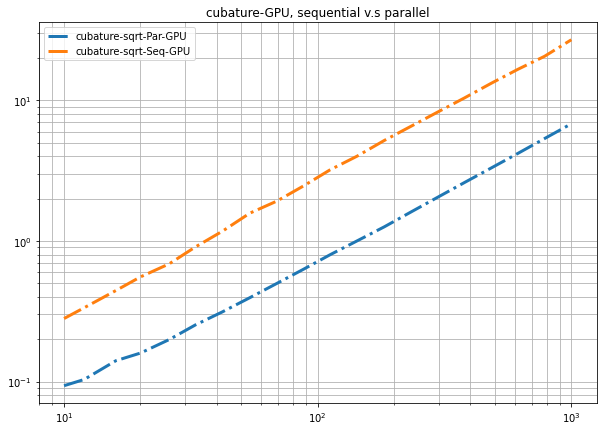

In [14]:
plt.figure(figsize=(10,7))
plt.loglog(lengths_space, gpu_cubature_sqrt_par_time, label="cubature-sqrt-Par-GPU", linestyle="-.", linewidth=3)
plt.loglog(lengths_space, gpu_cubature_sqrt_seq_time, label="cubature-sqrt-Seq-GPU", linestyle="-.", linewidth=3)

plt.grid(True, which="both")
plt.title("cubature-GPU, sequential v.s parallel")
plt.legend()
plt.show()

In [18]:
filtering_res = filtering(ys, chol_init, sqrt_transition_model, sqrt_observation_model, cubature, initial_states_sqrt, True)

In [28]:
spec_filtering = lambda : filtering(ys, chol_init, sqrt_transition_model, sqrt_observation_model, cubature, initial_states_sqrt, True)

In [29]:
filtering_jaxpr = jax.make_jaxpr(spec_filtering)()

In [30]:
filtering_jaxpr

{ lambda a:f64[1001,5] b:f64[1001,5,5] c:f64[5] d:f64[5,5] e:f64[5,10] f:i64[5] g:f64[10]
    h:f64[1,10] i:f64[10,1] j:f64[5,5] k:f64[5] l:f64[5,10] m:f64[2] n:f64[2] o:f64[10]
    p:f64[1,10] q:f64[10,1] r:f64[2,2] s:f64[2] t:f32[1000,2]; . let
    u:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 0
    v:f64[1000,5] = gather[
      dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1), collapsed_slice_dims=(), start_index_map=(0,))
      fill_value=None
      indices_are_sorted=True
      mode=GatherScatterMode.PROMISE_IN_BOUNDS
      slice_sizes=(1000, 5)
      unique_indices=True
    ] a u
    w:f64[1000,5] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(1000, 5)
    ] v
    x:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 0
    y:f64[1000,5,5] = gather[
      dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1, 2), collapsed_slice_dims=(), start_index_map=(0,))
      fill_value=None
      indices_are_sorted=True
      m

In [22]:
smoothing(sqrt_transition_model, filtering_res, cubature, initial_states_sqrt, True

MVNSqrt(mean=DeviceArray([[ 1.79996472, -1.20435104, -1.72239084,  0.02290087,
               2.43380679],
             [ 1.7828263 , -1.20408521, -1.70545753,  0.03008791,
               2.4329721 ],
             [ 1.76585766, -1.2037489 , -1.68843612,  0.0369935 ,
               2.43188142],
             ...,
             [ 0.54121006, -0.38268165, -0.18081399,  0.21488959,
               1.98437165],
             [ 0.53941946, -0.38051074, -0.17739055,  0.2192186 ,
               1.98437163],
             [ 0.53766352, -0.37829688, -0.17388116,  0.22347832,
               1.98437163]], dtype=float64), chol=DeviceArray([[[ 0.30273472,  0.        ,  0.        ,  0.        ,
                0.        ],
              [-0.07276094,  0.13456888,  0.        ,  0.        ,
                0.        ],
              [-0.48459588,  0.32215358, -0.31872375,  0.        ,
                0.        ],
              [-0.08400899, -0.21904561,  0.22144642,  0.22193481,
                0.        ],

In [32]:
spec_smoothing = lambda : smoothing(sqrt_transition_model, filtering_res, cubature, initial_states_sqrt, True)
smoothing_jaxpr = jax.make_jaxpr(spec_smoothing)()

In [33]:
smoothing_jaxpr

{ lambda a:f64[1001,5] b:f64[1001,5,5] c:f64[1001,5] d:f64[1001,5,5] e:f64[5,10]
    f:i64[5] g:f64[10] h:f64[1,10] i:f64[10,1] j:f64[5,5] k:f64[5]; . let
    l:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 0
    m:f64[1000,5] = gather[
      dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1), collapsed_slice_dims=(), start_index_map=(0,))
      fill_value=None
      indices_are_sorted=True
      mode=GatherScatterMode.PROMISE_IN_BOUNDS
      slice_sizes=(1000, 5)
      unique_indices=True
    ] a l
    n:f64[1000,5] = broadcast_in_dim[
      broadcast_dimensions=(0, 1)
      shape=(1000, 5)
    ] m
    o:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 0
    p:f64[1000,5,5] = gather[
      dimension_numbers=GatherDimensionNumbers(offset_dims=(0, 1, 2), collapsed_slice_dims=(), start_index_map=(0,))
      fill_value=None
      indices_are_sorted=True
      mode=GatherScatterMode.PROMISE_IN_BOUNDS
      slice_sizes=(1000, 5, 5)
      unique_indices=